In [8]:
#!pip3 install plotly

In [9]:
import pandas as pd
import plotly.express as px
import numpy as np
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
pd.set_option("display.max_columns", 100)

In [10]:

df = pd.read_csv("data/data_all_dicamba.csv", sep=";")

Creating a feature `concentration_varied` to account for if there's a variation or not

In [11]:
df["concentration_varied"] = np.where(df["concentration"] == 0, 0, 1)

Calculating `time_diff` time difference between subsequent timestamps


In [12]:
df["date"] = pd.to_datetime(df["date"])

In [13]:
diff_l = []
for ind in range(df.shape[0]):
  try:
    diff_l.append((df["date"][ind+1]-df["date"][ind]).total_seconds() / 60.0)
      # break
  except:
    break

len(df["date"].to_list()), len(diff_l)
z = [0]
z.extend(diff_l)
df["time_diff"] = z

## EDA

Checking for correlations

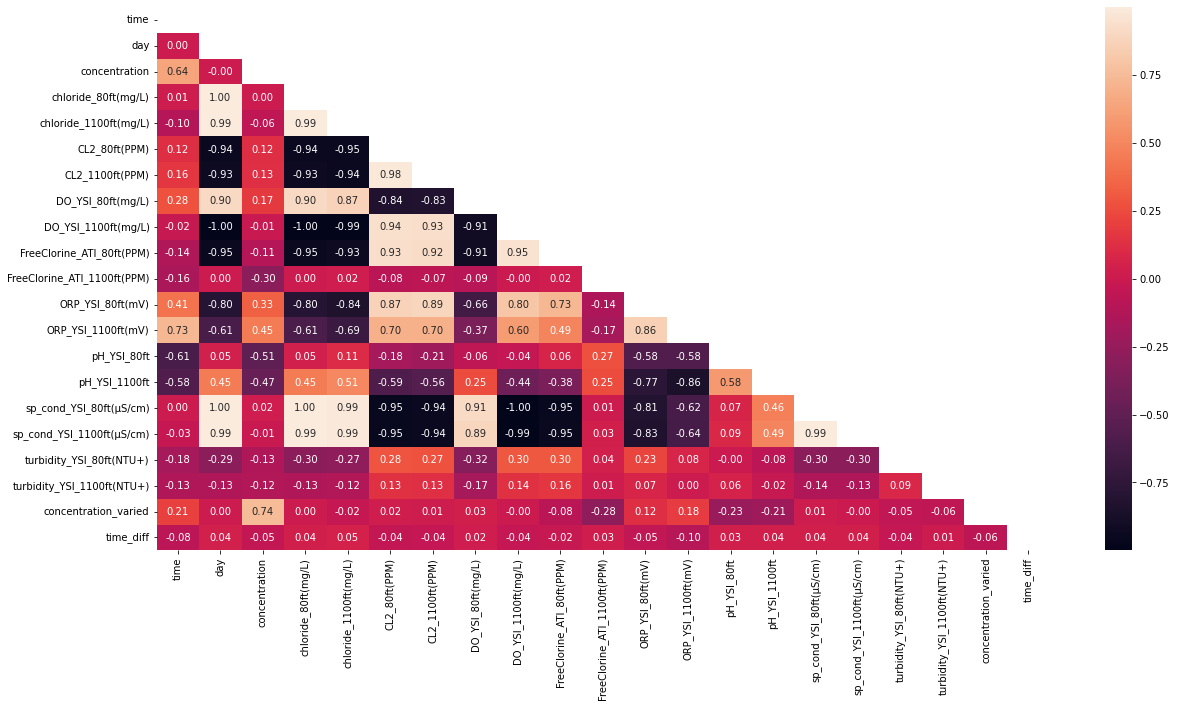

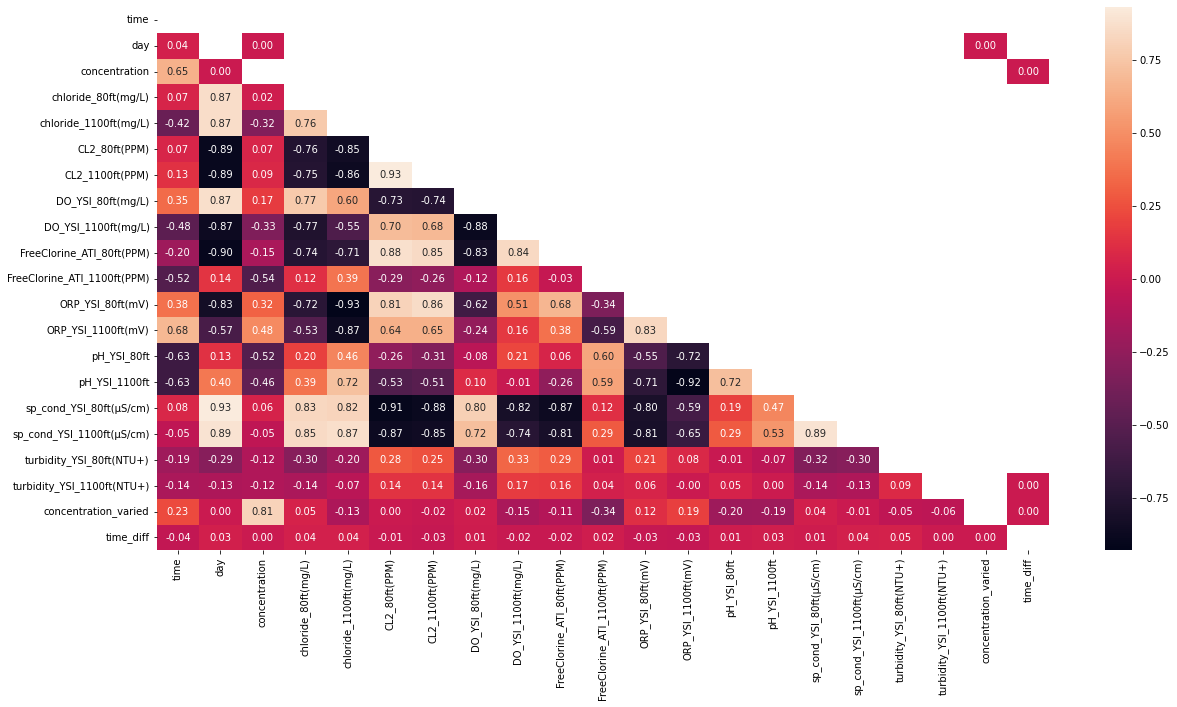

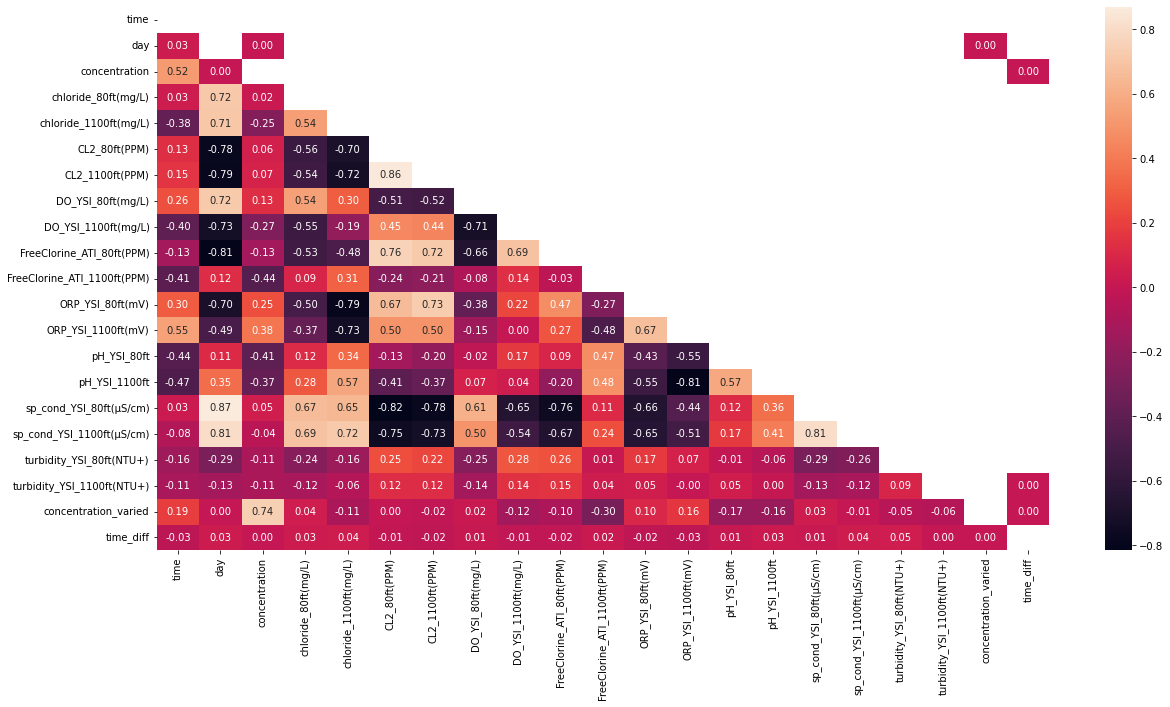

In [16]:
for cor in ["pearson", "spearman", "kendall"]:
  # Getting the Upper Triangle of the co-relation matrix
  matrix = np.triu(df.corr(cor))
  plt.figure(figsize=(20, 10))
  sns.heatmap(df.corr(cor), annot=True, fmt=".2f", mask=matrix)

#### Plots to understand the distribution of sesnsors' outputs w.r.t variation in concentration

### Observations:

- Spike (increment/decrement) are directly proportional to the amount of concetration of contaminant in the sample.
- Sometimes the effect of previous spike on the sensor outputs is maintinaed in the next experiment, despite of the concentration being 0.
- In majoirty of the sesory outputs, it's been obseved that the spike is short lived, i.e despite adding contamination, the sensor's output remains the same for the majority of the experiment. Post the spike, the sensors' readings drop and come to the level of the baseline.

### Numerically representing an experiment
- Hence, the median of each experiment cannnot account for it's representation.
- We will have to take into account the time it took to reach the spike. Hence, will need a number which is out of the scope of the delay by sensors/reaction time.   



In [9]:
res_df

NameError: name 'res_df' is not defined

In [10]:
for col in df.columns[5:]:
  fig = px.scatter(df, y = col, x = "date", color = "concentration")
  fig.show()

We need to create a sequential mapping to perform a pairwise comparison of subsequent experiments

> for instance, experiment at timestamp t+1 can only be compared with the experiment at timestamp at t+2.

In the code below, we're creating the experiment mappings and adding that to our data frame

In [13]:

var_buckets = [0]
var_b = 0
for ind in range(1, df.shape[0]):
  if df["concentration"][ind-1] != df["concentration"][ind]:
    var_b += 1
  var_buckets.append(var_b)

df["vars"] = var_buckets

### print(df["vars"])

0       0
1       0
2       0
3       0
4       0
       ..
631    11
632    11
633    11
634    11
635    11
Name: vars, Length: 636, dtype: int64


In [14]:
df.groupby(["concentration"]).max().reset_index()

,concentration,date,date(m/d/y),time,day,chloride_80ft(mg/L),chloride_1100ft(mg/L),CL2_80ft(PPM),CL2_1100ft(PPM),DO_YSI_80ft(mg/L),DO_YSI_1100ft(mg/L),FreeClorine_ATI_80ft(PPM),FreeClorine_ATI_1100ft(PPM),ORP_YSI_80ft(mV),ORP_YSI_1100ft(mV),pH_YSI_80ft,pH_YSI_1100ft,sp_cond_YSI_80ft(µS/cm),sp_cond_YSI_1100ft(µS/cm),turbidity_YSI_80ft(NTU+),turbidity_YSI_1100ft(NTU+),concentration_varied,time_diff,vars
0,0.0,2005-03-15 16:05:00,3/15/05,16.05,2,29.79,38.08,1.19,1.20,12.10,11.49,1.06,1.00,687,748,8.77,8.85,348,348,0.7,-0.7,0,5375.0,10
1,0.8,2005-03-15 12:00:00,3/15/05,13.10,2,29.77,37.74,1.17,1.18,12.02,11.48,1.06,1.01,680,741,8.77,8.85,349,348,0.7,-0.7,1,1.0,7
2,1.3,2005-03-15 15:40:00,3/15/05,15.40,2,29.67,36.85,1.18,1.20,12.10,11.48,1.05,1.01,688,749,8.72,8.83,348,348,0.7,-0.7,1,1.0,9
3,2.6,2005-03-15 17:20:00,3/15/05,17.20,2,29.70,36.62,1.20,1.22,12.13,11.42,1.06,0.95,695,751,8.72,8.84,349,348,0.7,-0.7,1,1.0,11


In [16]:
df_t = df[["concentration", "chloride_80ft(mg/L)", "time_diff", "vars"]]

In [17]:
df_t.groupby(["vars", "concentration"])["chloride_80ft(mg/L)"].max().reset_index().rename(columns = {"chloride_80ft(mg/L)": "chloride_80ft(mg/L)_max"})

,vars,concentration,chloride_80ft(mg/L)_max
0,0,0.0,25.32
1,1,0.8,25.34
2,2,0.0,25.34
3,3,1.3,25.32
4,4,0.0,25.29
5,5,2.6,25.38
6,6,0.0,29.54
7,7,0.8,29.77
8,8,0.0,29.79
9,9,1.3,29.67


In [18]:
df_max = df_t.groupby(["vars", "concentration"])["chloride_80ft(mg/L)"].max().reset_index().rename(columns = {"chloride_80ft(mg/L)": "chloride_80ft(mg/L)_max"})
df_min = df_t.groupby(["vars", "concentration"])["chloride_80ft(mg/L)"].min().reset_index().rename(columns = {"chloride_80ft(mg/L)": "chloride_80ft(mg/L)_min"})
df_std = df_t.groupby(["vars", "concentration"])["chloride_80ft(mg/L)"].std().reset_index().rename(columns = {"chloride_80ft(mg/L)": "chloride_80ft(mg/L)_std"})
df_tf_p = df_t.groupby(["vars", "concentration"])["chloride_80ft(mg/L)"].quantile(.25).reset_index().rename(columns = {"chloride_80ft(mg/L)": "chloride_80ft(mg/L)_q_25"})
df_sf_p = df_t.groupby(["vars", "concentration"])["chloride_80ft(mg/L)"].quantile(.75).reset_index().rename(columns = {"chloride_80ft(mg/L)": "chloride_80ft(mg/L)_q_75"})
df_mean = df_t.groupby(["vars", "concentration"])["chloride_80ft(mg/L)"].mean().reset_index().rename(columns = {"chloride_80ft(mg/L)": "chloride_80ft(mg/L)_mean"})
df_med = df_t.groupby(["vars", "concentration"])["chloride_80ft(mg/L)"].median().reset_index().rename(columns = {"chloride_80ft(mg/L)": "chloride_80ft(mg/L)_med"})

df_res = pd.concat([df_max, df_min.iloc[:, -1], df_std.iloc[:, -1], df_tf_p.iloc[:, -1], df_sf_p.iloc[:, -1], df_mean.iloc[:, -1], df_med.iloc[:, -1]], axis=1)


In [21]:
df_res

,vars,concentration,chloride_80ft(mg/L)_max,chloride_80ft(mg/L)_min,chloride_80ft(mg/L)_std,chloride_80ft(mg/L)_q_25,chloride_80ft(mg/L)_q_75,chloride_80ft(mg/L)_mean,chloride_80ft(mg/L)_med
0,0,0.0,25.32,25.22,0.030427,25.240,25.280,25.265161,25.26
1,1,0.8,25.34,25.22,0.030561,25.280,25.320,25.297200,25.30
2,2,0.0,25.34,25.21,0.023764,25.270,25.290,25.282258,25.28
3,3,1.3,25.32,25.16,0.034142,25.240,25.280,25.255467,25.26
4,4,0.0,25.29,25.19,0.024486,25.220,25.250,25.239355,25.24
5,5,2.6,25.38,25.17,0.053846,25.230,25.320,25.273733,25.28
6,6,0.0,29.54,29.22,0.078093,29.340,29.440,29.384194,29.37
7,7,0.8,29.77,29.37,0.095349,29.530,29.670,29.597600,29.61
8,8,0.0,29.79,29.59,0.049624,29.685,29.745,29.713226,29.72
9,9,1.3,29.67,29.41,0.058956,29.520,29.600,29.558400,29.56


### Comparing the experiments to obtain threshold

- As mentioned previously, there's no absolute threshold for every sensors' outputs. This is due to the fact that our baseline keeps changing susequently with each experiment.
- Hence, we need to calculate the ratios between the spike and the baseline previous to that experiment, as mentioned previously these ratios are to be performaed pairwise.
> Hence, we created the mappings.
- In order to perform the ratios, we need a numeric value to represent the entire distribution of every experiment.
  - We cannot consider mean and median here, this is due to the fact of delay in senroy outputs (mentioned in EDA).
  - Therefore, we'll consider more extreme values to get those numbers.
  - As mentioned in the EDA, contamination causes both increment and decrement in readings.
    - Hence, we need to take two numericals as representatives of each sensor.
    > As compared to analytics done for initial contaminations, in this case the much differences haven't been observed among contaminated and un-contaminated distributions.

    > Hence, we need to use more extreme quantiles.

  - We're taking `0.92 quantile` as a numeric representation for increment, and `0.27` as a numeric representation for decrement.
  - Again, these extreme quantiles are considered simply because majority of the data points are equivalent to adjacent baseline readings. These extreme quantiles help us ignore those values. The precise number was obtained by experiments, these delivered the most sensible ratios (in terms of data representation)



In [22]:

df_piv_inc = df.groupby(["vars", "concentration"]).quantile(0.92).reset_index()
df_piv_dec = df.groupby(["vars", "concentration"]).quantile(0.27).reset_index()


/var/folders/0m/xmkg_d4s05j9zcbpwwncd19w0000gn/T/ipykernel_11200/4149425272.py:1: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.

/var/folders/0m/xmkg_d4s05j9zcbpwwncd19w0000gn/T/ipykernel_11200/4149425272.py:2: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.



### Getting thresholds
  - After getting the numeric entities that represent each experiment, all we need to do is calculate pairwise ratios.
  - Later we simply take the mean of these ratios, which gives us the threshold w.r.t the baseline previous to the experiment.
  - This simply means, given a baseline reading of `x` and the mean ratio for that particular sensor as `1.032`, the sample is to be considered contaminated if reading of the sensor is more than `1.032x`.

In [23]:
ratio_l = []
for i_1, i_2 in zip(range(df_piv_inc.shape[0]), range(1, df_piv_inc.shape[0])):
  if i_1%2==0:
    x = (df_piv_inc.iloc[i_2, 3:]/df_piv_inc.iloc[i_1, 3:])
    x["vars_r"] = f"{df_piv_inc.iloc[i_2, 0]}_{df_piv_inc.iloc[i_1, 0]}"
    x["conc_r"] = f"{df_piv_inc.iloc[i_1, 1]}_{df_piv_inc.iloc[i_1, 1]}"
    ratio_l.append(x)

ratio_inc_df = pd.concat(ratio_l, axis = 1)

ratio_l = []
for i_1, i_2 in zip(range(df_piv_dec.shape[0]), range(1, df_piv_dec.shape[0])):
  if i_1%2==0:
    x = (df_piv_dec.iloc[i_2, 3:]/df_piv_dec.iloc[i_1, 3:])
    x["vars_r"] = f"{df_piv_dec.iloc[i_2, 0]}_{df_piv_dec.iloc[i_1, 0]}"
    x["conc_r"] = f"{df_piv_dec.iloc[i_2, 1]}_{df_piv_dec.iloc[i_1, 1]}"
    ratio_l.append(x)

ratio_dec_df = pd.concat(ratio_l, axis = 1)


In [24]:
ratio_dec_df_T = ratio_dec_df.T
ratio_inc_df_T = ratio_inc_df.T


In [25]:
res_df = ratio_inc_df_T.drop(["time_diff", "vars_r", "day"], axis=1).mean().reset_index()
res_df.columns = ["sensors", "ratios_inc"]
res_df["ratios_dec"] = ratio_dec_df_T.drop(["time_diff", "vars_r", "day"], axis=1).mean().reset_index()[0]

/var/folders/0m/xmkg_d4s05j9zcbpwwncd19w0000gn/T/ipykernel_11200/2931433019.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/var/folders/0m/xmkg_d4s05j9zcbpwwncd19w0000gn/T/ipykernel_11200/2931433019.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [26]:
res_df

,sensors,ratios_inc,ratios_dec
0,time,1.095247,1.054854
1,chloride_80ft(mg/L),1.001155,1.000264
2,chloride_1100ft(mg/L),0.995515,0.993586
3,CL2_80ft(PPM),1.001248,0.998488
4,CL2_1100ft(PPM),1.004308,0.999965
5,DO_YSI_80ft(mg/L),1.001444,0.999843
6,DO_YSI_1100ft(mg/L),0.998356,0.996715
7,FreeClorine_ATI_80ft(PPM),0.996779,0.996746
8,FreeClorine_ATI_1100ft(PPM),0.990388,0.981004
9,ORP_YSI_80ft(mV),1.006173,1.001456


In [27]:
res_df

,sensors,ratios_inc,ratios_dec
0,time,1.095247,1.054854
1,chloride_80ft(mg/L),1.001155,1.000264
2,chloride_1100ft(mg/L),0.995515,0.993586
3,CL2_80ft(PPM),1.001248,0.998488
4,CL2_1100ft(PPM),1.004308,0.999965
5,DO_YSI_80ft(mg/L),1.001444,0.999843
6,DO_YSI_1100ft(mg/L),0.998356,0.996715
7,FreeClorine_ATI_80ft(PPM),0.996779,0.996746
8,FreeClorine_ATI_1100ft(PPM),0.990388,0.981004
9,ORP_YSI_80ft(mV),1.006173,1.001456


### Selecting threshold ratio

- Using the EDA plots, we conclude the pattern.
  > When the `ratios_inc` < 0, there's a decrement in sensor's readings due to contamination.
  > Hence, in such a case we will use `ratios_dec` as threshold, under this scenario, given `x` as a baseline and having `0.923` as the retio of decrement, the contaminant will be considered contaminated if the readings are below `0.923x`


In [28]:
def get_thresh(x):	
  if x["ratios_dec"] < 1:
    return x["ratios_dec"]
  return x["ratios_inc"]

In [29]:
res_df["thresh"] = res_df.apply(lambda x: get_thresh(x), axis=1)

In [30]:
def get_pos_neg(row):
  if row["thresh"] == row["ratios_dec"]:
    return "lesser"
  if row["thresh"] == row["ratios_inc"]:
    return "more"

### Metadata

We're also making a column for inference which directs if the threshold is derived from increment set or decrement set

In [31]:
res_df["set_mapping"] = res_df.apply(lambda x: get_pos_neg(x), axis=1)

## Threshold dataframe

In [32]:
res_df

,sensors,ratios_inc,ratios_dec,thresh,set_mapping
0,time,1.095247,1.054854,1.095247,more
1,chloride_80ft(mg/L),1.001155,1.000264,1.001155,more
2,chloride_1100ft(mg/L),0.995515,0.993586,0.993586,lesser
3,CL2_80ft(PPM),1.001248,0.998488,0.998488,lesser
4,CL2_1100ft(PPM),1.004308,0.999965,0.999965,lesser
5,DO_YSI_80ft(mg/L),1.001444,0.999843,0.999843,lesser
6,DO_YSI_1100ft(mg/L),0.998356,0.996715,0.996715,lesser
7,FreeClorine_ATI_80ft(PPM),0.996779,0.996746,0.996746,lesser
8,FreeClorine_ATI_1100ft(PPM),0.990388,0.981004,0.981004,lesser
9,ORP_YSI_80ft(mV),1.006173,1.001456,1.006173,more


### Modelling

- Due to less data, we're training a simple linear model, i.e Logistic Regression
- We're validating the model performance using cross-validation. Once satisfied with the performance, we fitted the model with the entire data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
X = df.drop(["date",	"date(m/d/y)",	"time", "day", "concentration", "concentration_varied", "time_diff", "vars"], axis=1)
y = df["concentration_varied"]

In [ ]:
from sklearn.model_selection import cross_val_score
clf = LogisticRegression( max_iter=300)
scores = cross_val_score(clf, X, y, cv=5)

In [ ]:
scores

array([0.546875  , 0.81102362, 0.82677165, 0.70866142, 0.70866142])

Fitting the model

In [ ]:
clf.fit(X, y)

LogisticRegression(max_iter=300)

Predictions

In [ ]:
clf.predict(X.iloc[:1, :])

array([0])

In [ ]:
coef_df = pd.DataFrame({
    "features": X.columns,
    "importance":clf.coef_[0],
})

In [ ]:
coef_df

,features,importance
0,chloride_80ft(mg/L),3.458900
1,chloride_1100ft(mg/L),-0.659672
2,CL2_80ft(PPM),-1.254563
3,CL2_1100ft(PPM),-1.924406
4,DO_YSI_80ft(mg/L),-1.035168
5,DO_YSI_1100ft(mg/L),-0.272094
6,FreeClorine-ATI_80ft(PPM),-2.943885
7,FreeClorine-ATI_1100ft(PPM),-2.470738
8,FreeClorine-Depolox_80ft(PPM),-1.774067
9,FreeClorine-Depolox_1100ft(PPM),-2.597312
